<a href="https://colab.research.google.com/github/arpansd/ISIM-Project/blob/master/julian_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from keras.preprocessing import sequence

import matplotlib.pyplot as plt
from scipy.sparse import data
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout, LSTM, Concatenate
from keras.layers.merge import concatenate
from keras import Input, Model

from keras.preprocessing.image import array_to_img, img_to_array, load_img, image_dataset_from_directory
from keras.preprocessing.sequence import TimeseriesGenerator
# from keras.utils import plot_model

from tensorflow.keras.utils import plot_model
from PIL import Image

import pandas as pd
from pandas import datetime
from pandas import read_csv
import numpy as np
np.set_printoptions(precision=4)

2021-09-13 19:42:55.675832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/lib64:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2021-09-13 19:42:55.675853: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/tmp/ipykernel_387490/2950976567.py:21: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [ ]:

def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    # model = keras.Sequential()
    img_input = Input(shape=shape)
    conv1 = Conv2D(64, (3, 3), input_shape=shape,
                   padding='same', activation='relu')(img_input)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1)
    b_norm1 = BatchNormalization(momentum=momentum)(conv2)
    max_pool1 = MaxPool2D()(b_norm1)

    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(max_pool1)
    conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    b_norm2 = BatchNormalization(momentum=momentum)(conv4)

    max_pool2 = MaxPool2D()(b_norm2)

    conv5 = Conv2D(256, (3, 3), padding='same', activation='relu')(max_pool2)
    conv6 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv5)
    b_norm3 = BatchNormalization(momentum=momentum)(conv6)

    max_pool3 = MaxPool2D()(b_norm3)

    conv7 = Conv2D(512, (3, 3), padding='same', activation='relu')(b_norm3)
    conv8 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv7)
    b_norm4 = BatchNormalization(momentum=momentum)(conv8)

    # flatten...
    flat = GlobalMaxPool2D()(b_norm4)
    model = Model(inputs=img_input, outputs=flat)
    plot_model(model, to_file='convnet.png')
    return model


def regression_model(nbout=7, sequence_length=1, img_in_shape=(1, 480, 640, 3),):
    #img_in_shape[0] = sequence_length
    img_shape = list(img_in_shape)
    img_shape[0] = sequence_length
    img_in_shape = tuple(img_shape)
    convnet = build_convnet(img_in_shape[1:])
    convnet.summary()

    robot_input = Input(shape=(sequence_length, 7),
                        dtype='float32', name="robot_pose")
    img_sequence_input = Input(shape=img_in_shape, name="image")
    td = TimeDistributed(convnet, name="convolutional")(img_sequence_input)

    lstm_img = LSTM(256, return_sequences=True)(td)
    dense_img = Dense(32)(lstm_img)
    model_img = Model(inputs=img_sequence_input,
                      outputs=dense_img, name="image_model")

    lstm_pose = LSTM(128, return_sequences=True)(robot_input)
    dense_pose = Dense(32)(lstm_pose)
    model_pose = Model(inputs=robot_input, outputs=dense_pose,
                       name="robot_pose_model")

    model_img.summary()
    model_pose.summary()
    print(model_pose.input_shape, model_img.input_shape[0])

    merged = Concatenate(axis=-1)([dense_img, dense_pose])
    lstm = LSTM(64, return_sequences=True)(merged)
    dense1 = Dense(1024, activation='relu')(lstm)
    drop1 = Dropout(.5)(dense1)
    dense2 = Dense(512, activation='relu')(drop1)
    drop2 = Dropout(.5)(dense2)
    dense3 = Dense(128, activation='relu')(drop2)
    drop3 = Dropout(.5)(dense3)
    dense4 = Dense(64, activation='relu')(drop3)
    dense5 = Dense(nbout, activation="linear",
                   name="cam-flanch-transform")(dense4)
    model = Model(inputs=[img_sequence_input, robot_input], outputs=dense5)

    return model


def load_images(images):
    images_dataset = []
    for path in images:
        #name = os.path.join(top_dir, file)
        img = np.array(Image.open(path))
        images_dataset.append(img)

    return np.asfarray(images_dataset)  # astype(np.float32)


## Creating the model

2021-09-13 19:42:56.720028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-13 19:42:56.720532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/lib64:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2021-09-13 19:42:56.720598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/lib64:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2021-09-13 19:42:56.720649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasL

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 480, 640, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 480, 640, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 480, 640, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 240, 320, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 320, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 240, 320, 128)     147584

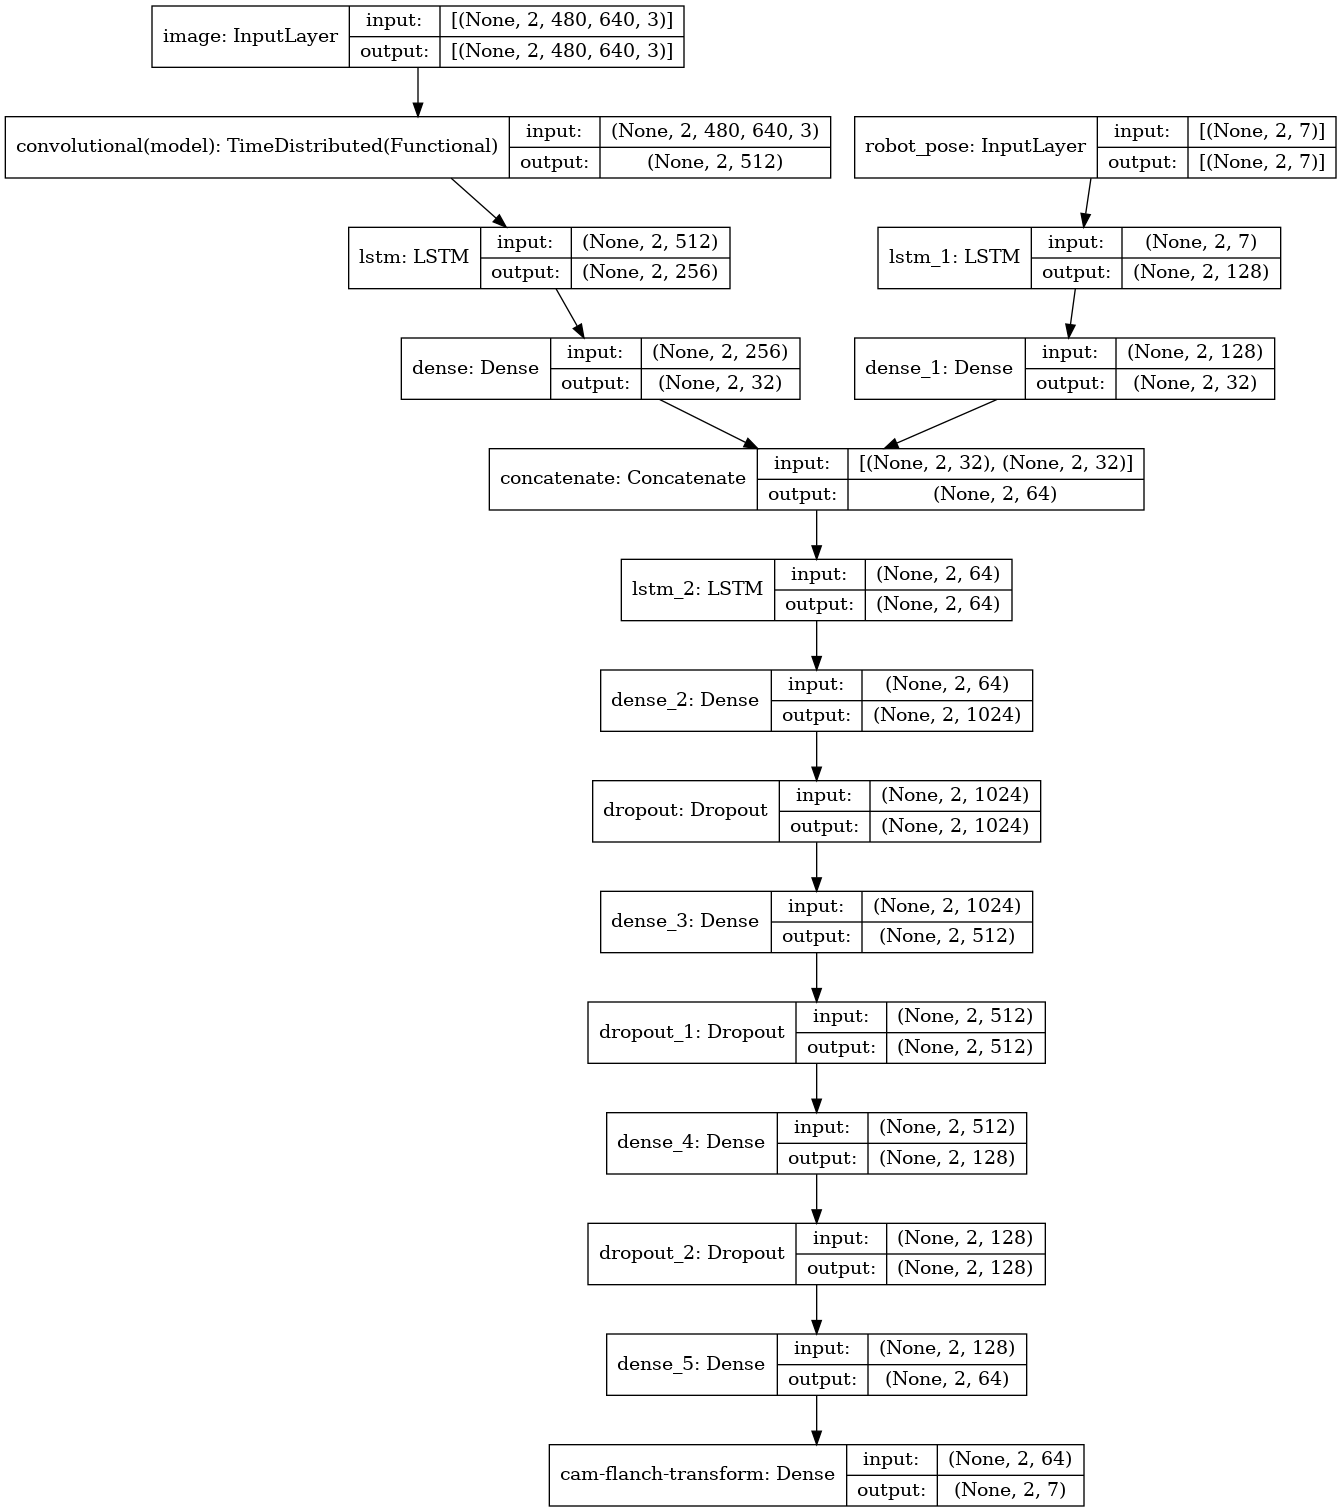

In [ ]:
sequence_length = 2
batch_size = 1

model = regression_model(sequence_length=sequence_length)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

## Preparing the data

For the time series data the shape of a batch should be `(sampels, timesteps, features)` (or for the image input `(batch_size, sequence_length, image.shape)`). 

Using a custom generator class for multi variant data as described [here](https://stackoverflow.com/questions/49404993/how-to-use-fit-generator-with-multiple-inputs). 

In [ ]:
from tensorflow.keras.utils import Sequence


class CalibrationSequenceDataGenerator(Sequence):

    def __init__(self, images, poses, transforms, sequence_length, batch_size):

        self.image_generator = TimeseriesGenerator(
            images, transforms, length=sequence_length, batch_size=batch_size, stride=sequence_length)

        self.pose_generator = TimeseriesGenerator(
            poses, transforms, length=sequence_length, batch_size=batch_size, stride=sequence_length)

    def __len__(self):
        return self.image_generator.__len__()

    def __getitem__(self, index):
        images_batch, y_batch = self.image_generator.__getitem__(index)
        poses_batch, _ = self.pose_generator.__getitem__(index)

        # Calculate the relative movement between to two samples in a sequence
        poses_relative = []
        for i in range(0,len(poses_batch[0])): 
            if i==0: 
                poses_relative.append(np.array([.0, .0, .0, .0, .0, .0, .0]))
            else: 
                poses_relative.append((poses_batch[0][i,:]-poses_batch[0][i-1]))
                
        poses_batch = np.reshape(np.array(poses_relative), poses_batch.shape)

        x_batch = [images_batch, poses_batch]

        return x_batch, y_batch

train_data_path = os.path.join(
    '..', 'data', 'datasets', 'cam_flanch_calib', 'gt_Dataset')
train_data_file = os.path.join(train_data_path, 'ef_poses.csv')
train_image_path = os.path.join(train_data_path, 'sim_images')
train_data = read_csv(train_data_file, header=0, parse_dates=[
                      0], index_col=0, squeeze=True)

split = 0.85
train_values = train_data.values[:round(len(train_data)*split),:]
test_values = train_data.values[round(len(train_data)*split):,:]

train_robot_poses = train_values[:, 1:8]
train_robot_poses = train_robot_poses
train_cam_transforms = train_values[:, 8:15]
train_cam_transforms = train_cam_transforms
train_images = train_values[:, 0]

for i in range(train_images.shape[0]):
    train_images[i] = os.path.join(
        train_image_path, f'{train_images[i]}.jpg')

test_robot_poses = test_values[:, 1:8]
test_cam_transforms = test_values[:, 8:15]
test_images = test_values[:,0]

for i in range(test_images.shape[0]):
    test_images[i] = os.path.join(
        train_image_path, f'{test_images[i]}.jpg')

print("Train Targets: ", train_robot_poses.shape, train_robot_poses[0, :])
print("Test Targets", test_robot_poses.shape, test_robot_poses[0, :])
print("Cameras: ", train_cam_transforms.shape, train_cam_transforms[0, :])
print("Images: ", train_images.shape, train_images[0])

# Get the indices where gt cam-flanch-transforms would be different within one sequence
def get_inidices_to_drop(transforms, length):
    dropping_indicies = []
    for i, t in enumerate(transforms): 
        if i<len(transforms[:,0])-1 and not np.array_equal(transforms[i+1,:], transforms[i,:]): 
            for j in reversed(range(i-i%length,i+1)): 
                dropping_indicies.append(j)
    return dropping_indicies

# Drop values that not fit the sequence length
dropping_indicies = get_inidices_to_drop(train_cam_transforms, sequence_length)
train_cam_transforms = np.delete(train_cam_transforms, dropping_indicies, axis=0)
train_robot_poses = np.delete(train_robot_poses, dropping_indicies, axis=0)
train_images = np.delete(train_images, dropping_indicies, axis=0)

dropping_indicies = get_inidices_to_drop(test_cam_transforms, sequence_length)
test_cam_transforms = np.delete(test_cam_transforms, dropping_indicies, axis=0)
test_robot_poses = np.delete(test_robot_poses, dropping_indicies, axis=0)
test_images = np.delete(test_images, dropping_indicies, axis=0)

# Create the generators 
train_image_data = load_images(train_images)/255
train_generator = CalibrationSequenceDataGenerator(train_image_data, np.asfarray(train_robot_poses), np.asfarray(
    train_cam_transforms), sequence_length=sequence_length, batch_size=batch_size)

test_image_data = load_images(test_images)/255
test_generator = CalibrationSequenceDataGenerator(test_image_data, np.asfarray(
    test_robot_poses), np.asfarray(test_cam_transforms), sequence_length=sequence_length, batch_size=batch_size)


Train Targets:  (170, 7) [0.970629166010246 0.2557962950579684 0.2892980186399793
 -0.7072129908281829 -0.7069993818768122 0.0008849797604635
 0.0009361840019993]
Test Targets (30, 7) [0.3704134788270509 0.2562660241875235 0.5926280925533015
 0.7000015781633205 0.7001922545743896 0.0993013971416311
 0.0993369504696708]
Cameras:  (170, 7) [0.09 0.0 -0.015 1.0 0.0 0.0 1.0341155355510723e-13]
Images:  (170,) ../data/datasets/cam_flanch_calib/gt_Dataset/sim_images/savedImage1.jpg


In [ ]:
print(f"Train image dataset shape: {train_image_data.shape}")
print(f"Train dataset length: {train_image_data.shape[0]}")
print(f"Test dataset length: {test_image_data.shape[0]}")
print(f"Sequence lenght: {sequence_length}")
print(f"Batch size:  {batch_size}")
print(f"Number of samples in train generator: {len(train_generator)}")
print(f"Number of samples in test generator: {len(test_generator)}")
print(f"Image batch shape: {train_generator[0][0][0].shape}")
print(f"Pose batch shape: {train_generator[0][0][1].shape}")
print(f"Transform shape: {train_generator[0][1][0].shape}")
print(f"Image feature shape: {train_generator[0][0][0][0][0].shape}")

Train image dataset shape: (151, 480, 640, 3)
Train dataset length: 151
Test dataset length: 28
Sequence lenght: 2
Batch size:  1
Number of samples in train generator: 75
Number of samples in test generator: 13
Image batch shape: (1, 2, 480, 640, 3)
Pose batch shape: (1, 2, 7)
Transform shape: (7,)
Image feature shape: (480, 640, 3)


## Fitting the Model

In [ ]:
history = model.fit(train_generator, validation_data=test_generator, batch_size=batch_size, epochs=5)

Epoch 1/5


2021-09-13 19:42:58.375015: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


36/75 [=============>................] - ETA: 2:10 - loss: 0.0410 - mse: 0.0410 - mae: 0.1276 - mape: 29022342.0000

KeyboardInterrupt: 

## Plotting the loss curves

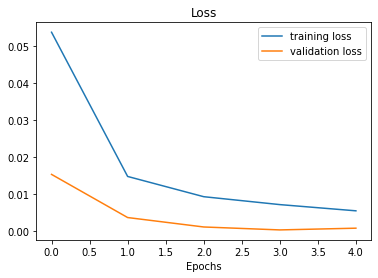

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(history.history['loss']))
  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='validation loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss_curves(history)
plt.show()

## Saving the mode

In [ ]:
import datetime

model_idx = 0
today = datetime.date.today()
t = f"{today.year}{today.month}{today.day}"
model.save(os.path.join('..', 'models', f'{t}_{model_idx}'))

INFO:tensorflow:Assets written to: ../models/2021913_0/assets


INFO:tensorflow:Assets written to: ../models/2021913_0/assets


## Making predictions

In [ ]:
np.set_printoptions(precision=4, suppress=True)
prediction = model.predict(test_generator[1][0])[0][-1]
gt = test_generator[1][1][-1]

print('Ground truth:')
print('\n'.join(['\t'.join([str(f'{cell:.4f}') for cell in gt])]))
print('Prediction:')
print('\n'.join(['\t'.join([str(f'{cell:.4f}') for cell in prediction])]))

Ground truth:
0.0700	0.0050	0.0020	0.9998	-0.0150	-0.0150	-0.0002
Prediction:
0.0613	-0.0101	-0.0104	0.9532	-0.0040	-0.0004	-0.0074


### Plot the prediction

In [ ]:
from spatialmath import * 

q_pred = prediction[3:]
t_pred = prediction[:3]
q_gt = gt[3:]
t_gt = gt[:3]

print(t_pred)

x = SE3(t_pred[0], t_pred[1], t_pred[2]) * UnitQuaternion(q_pred).SE3()
y = SE3(t_gt[0], t_gt[1], t_gt[2]) * UnitQuaternion(q_gt).SE3()
print(x, y)

[ 0.0613 -0.0101 -0.0104]
   0.9999    0.01548  -0.0006736  0.06129   
  -0.01548   0.9998    0.008438 -0.0101    
   0.0008041 -0.008427  1        -0.01037   
   0         0         0         1         
    0.9996    0.0008997 -0.02998   0.07      
   2.068e-13  0.9996    0.03      0.005     
   0.03     -0.02998   0.9991    0.002     
   0         0         0         1         



In [ ]:
from matplotlib.pyplot import figure

plt.figure()
figure(figsize=(12, 10), dpi=80)
x.plot(label='gt', length=0.01)
y.plot(label='pred', color='red', length=0.01)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>